#  Project 1 - Retail PGP

**DESCRIPTION**

**Problem Statement**

It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value)

## ``Project Task: Week 1``

**Data Cleaning:**

1. Perform a preliminary data inspection and data cleaning.

    a. Check for missing data and formulate an apt strategy to treat them.

    b. Remove duplicate data records.

    c. Perform descriptive analytics on the given data.

**Data Transformation:**

2. Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts.

    a. Create month cohorts and analyze active customers for each cohort.

    b. Analyze the retention rate of customers.
    
    
  > 
  >
**Code**

### Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import missingno as msno
from scipy import stats
import seaborn as sns
from textwrap import wrap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading train and test dataset in pandas dataframe
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

In [3]:
# Concatinate train & test dataset
df = pd.concat([train_df,test_df], axis=0)

In [4]:
print("Dimension of the Data set is", df.shape)
print()
df.head()

Dimension of the Data set is (541909, 8)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,558904,22292,HANGING CHICK YELLOW DECORATION,1,2011-07-04 16:18:00,1.25,NaN,United Kingdom
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom
3,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,15529.0,United Kingdom
4,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,14448.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 162572
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.2+ MB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


**Observation:**
> A look at the quantity column reveals there are some negative values. Those could be possibly the refunds. The refunds start from the 'C' in InvoiceNo.

> Minimum value for a ``Quantity`` is in negative and the same number is positive in the max; which means someone bought ``80,995`` products but then returned later. 

> If we look at the ``unit price``, all the quartiles are in single digit numbers but the max value is in thousands, which creates some doubt.

> Let's analyse all these all points & if required remove them from the data

In [7]:
# Checking all the records which were returned
df[df["InvoiceNo"].str.startswith('C',na=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
415,C549269,75049L,LARGE CIRCULAR MIRROR MOBILE,-9,2011-04-07 12:47:00,0.85,16701.0,United Kingdom
487,C572109,23064,CINDERELLA CHANDELIER,-1,2011-10-20 18:24:00,49.95,13350.0,United Kingdom
613,C537860,22180,RETROSPOT LAMP,-1,2010-12-08 16:15:00,9.95,16252.0,United Kingdom
834,C560540,23240,SET OF 4 KNICK KNACK TINS DOILEY,-1,2011-07-19 12:26:00,4.15,12415.0,Australia
874,C542910,20726,LUNCH BAG WOODLAND,-1,2011-02-01 15:38:00,1.45,17511.0,United Kingdom
...,...,...,...,...,...,...,...,...
162302,C558712,21735,TWO DOOR CURIO CABINET,-1,2011-07-01 13:06:00,12.75,17338.0,United Kingdom
162334,C550780,84507C,BLUE CIRCLES DESIGN MONKEY DOLL,-1,2011-04-20 13:39:00,2.55,17211.0,United Kingdom
162344,C553031,21533,RETROSPOT LARGE MILK JUG,-3,2011-05-12 19:43:00,4.95,13908.0,United Kingdom
162421,C542910,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1,2011-02-01 15:38:00,2.55,17511.0,United Kingdom


**Observation:**

> ``9288`` Products were returned back, we can remove all these records.

In [8]:
# Deleting all the records which were returned 
df=df[~df['InvoiceNo'].str.startswith('C',na=False)]

In [9]:
df.shape

(532621, 8)

In [10]:
# Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

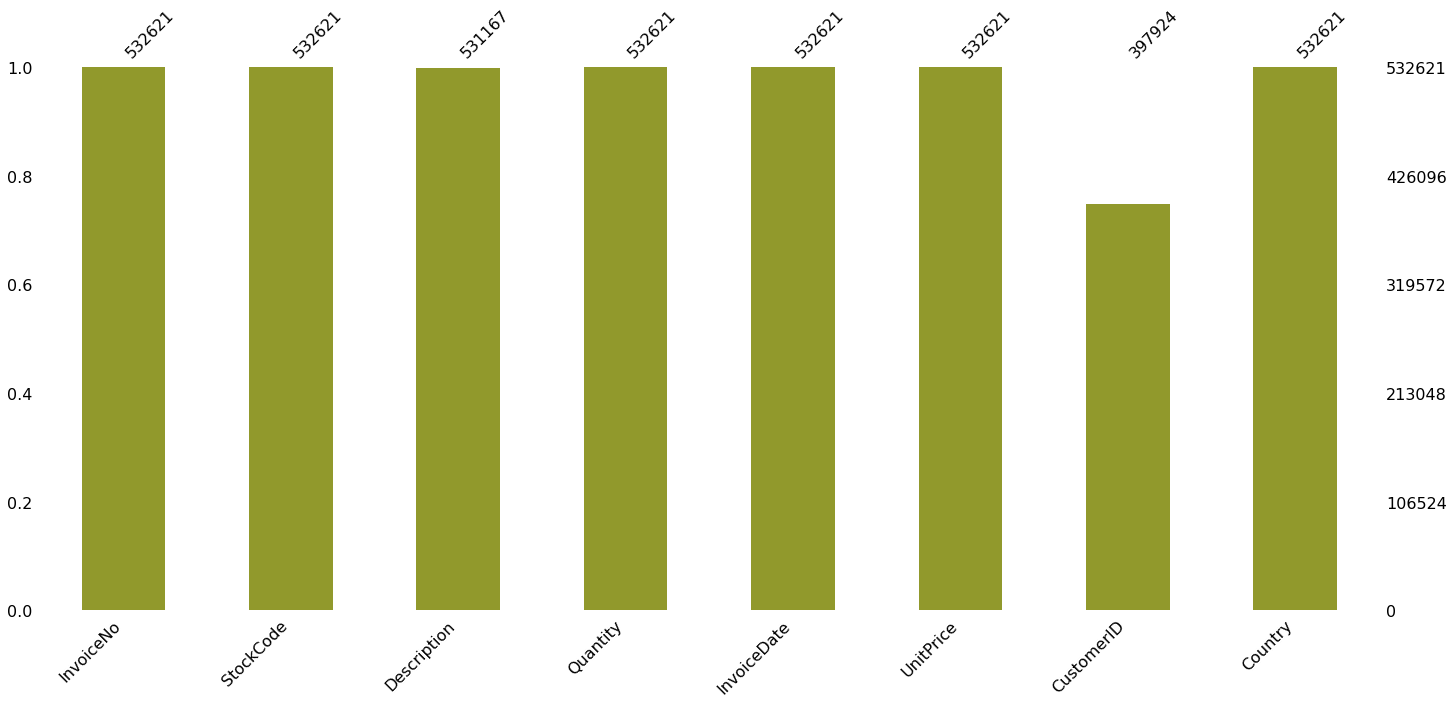

In [11]:
# Checking missing values with the help of MSNO graph
msno.bar(df, color='#91992C');

In [12]:
# Deleting all the missing values
df = df[pd.notnull(df['CustomerID'])]

**Observation:**

> We can include one more field named ``Total Sales`` which represents the total order amount that is simply the product of ``UnitPrice`` and ``Quantity``

In [13]:
# Creating a new column Total Sales 
df['Total_sales'] = df['Quantity'] * df['UnitPrice']

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,397924.0,13.021823,180.420210,1.0,2.00,6.00,12.00,80995.00
UnitPrice,397924.0,3.116174,22.096788,0.0,1.25,1.95,3.75,8142.75
CustomerID,397924.0,15294.315171,1713.169877,12346.0,13969.00,15159.00,16795.00,18287.00
Total_sales,397924.0,22.394749,309.055588,0.0,4.68,11.80,19.80,168469.60


**Observation:**

>A look at the distribution for ``Quantity`` and ``Total_sales`` show that the majority of values are in single digits. There however seems to be outliers of up to ``80,995`` for order quantity and ``168469`` for total sales


In [15]:
df[(df['Quantity'] > 500) & (df['Total_sales'] > 1000)].head(14)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_sales
440,548011,22630,DOLLY GIRL LUNCH BOX,640,2011-03-29 11:14:00,1.65,14646.0,Netherlands,1056.00
4766,570094,22273,FELTCRAFT DOLL MOLLY,720,2011-10-07 11:56:00,2.55,16029.0,United Kingdom,1836.00
6586,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40
9074,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom,1003.20
14761,567423,23285,PINK VINTAGE SPOT BEAKER,1944,2011-09-20 11:05:00,1.08,17450.0,United Kingdom,2099.52
15029,554845,85123A,WHITE HANGING HEART T-LIGHT HOLDER,608,2011-05-26 19:49:00,3.24,17450.0,United Kingdom,1969.92
15177,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,1008.00
17773,574294,22086,PAPER CHAIN KIT 50'S CHRISTMAS,1020,2011-11-03 15:47:00,2.55,16333.0,United Kingdom,2601.00
30612,558526,23170,REGENCY TEA PLATE ROSES,720,2011-06-30 11:01:00,1.45,17949.0,United Kingdom,1044.00
36091,558554,23245,SET OF 3 REGENCY CAKE TINS,576,2011-06-30 12:50:00,4.15,17949.0,United Kingdom,2390.40


**Observation:**

> ``InvoiceNO`` ``581483`` is the same which we saw earlier that this was returned back by the customer. So we can drop this.

In [16]:
# Deleting record for Inovice no. 581483
df.drop(43525, axis =0, inplace = True)

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,397922.0,12.818334,126.770315,1.0,2.00,6.00,12.00,74215.00
UnitPrice,397922.0,3.116180,22.096843,0.0,1.25,1.95,3.75,8142.75
CustomerID,397922.0,15294.310475,1713.172833,12346.0,13969.00,15159.00,16795.00,18287.00
Total_sales,397922.0,21.971467,155.592056,0.0,4.68,11.80,19.80,77183.60


**Observation:** 

> We can still see there is one more outlier in ``Quantity``, someone ordered ``74K`` items, we can remove that too

In [18]:
df[df['Quantity'] == 74215]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_sales
322892,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


In [19]:
# Removing the record for invoice number 541431
df.drop(322892, axis =0, inplace = True)

In [20]:
orders_n = df.groupby(['CustomerID']) ['InvoiceNo'].nunique()
more_than_one = np.sum(orders_n > 1) / df['CustomerID'].nunique()
print(f'{100 * more_than_one:.2f}% of customers ordered more than once')

65.56% of customers ordered more than once


**Observation:**

> We have already got a very useful piece of information here. We see there is some kind of retention rate, as **``65.56%``** of customers have ordered from the website atleast more than once

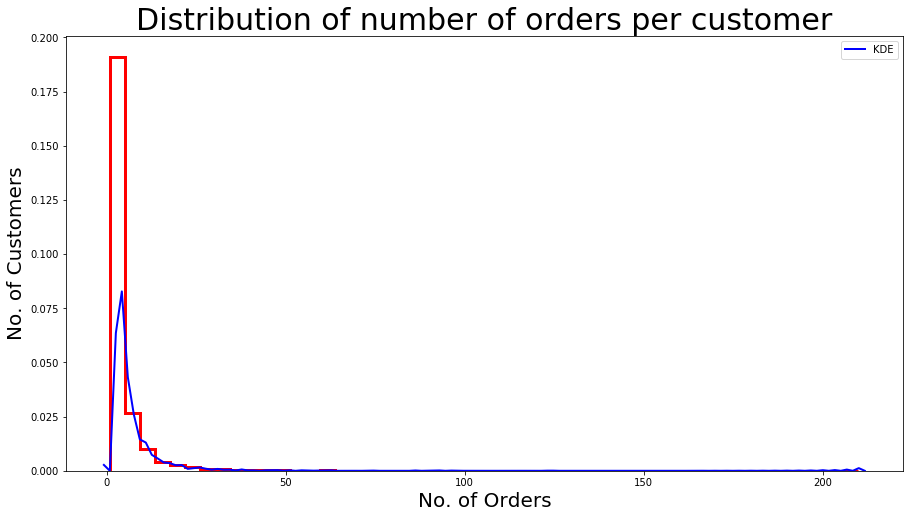

In [21]:
plt.figure(figsize=(15,8))
plt.style.use('_classic_test_patch')
px = sns.distplot(orders_n, hist = True, rug_kws={"color": "r"},
                  kde_kws={"color": "b", "lw": 2, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "r"})

px.set_title('Distribution of number of orders per customer', fontsize = 30)
px.set_xlabel('No. of Orders', fontsize = 20)
px.set_ylabel('No. of Customers', fontsize = 20);

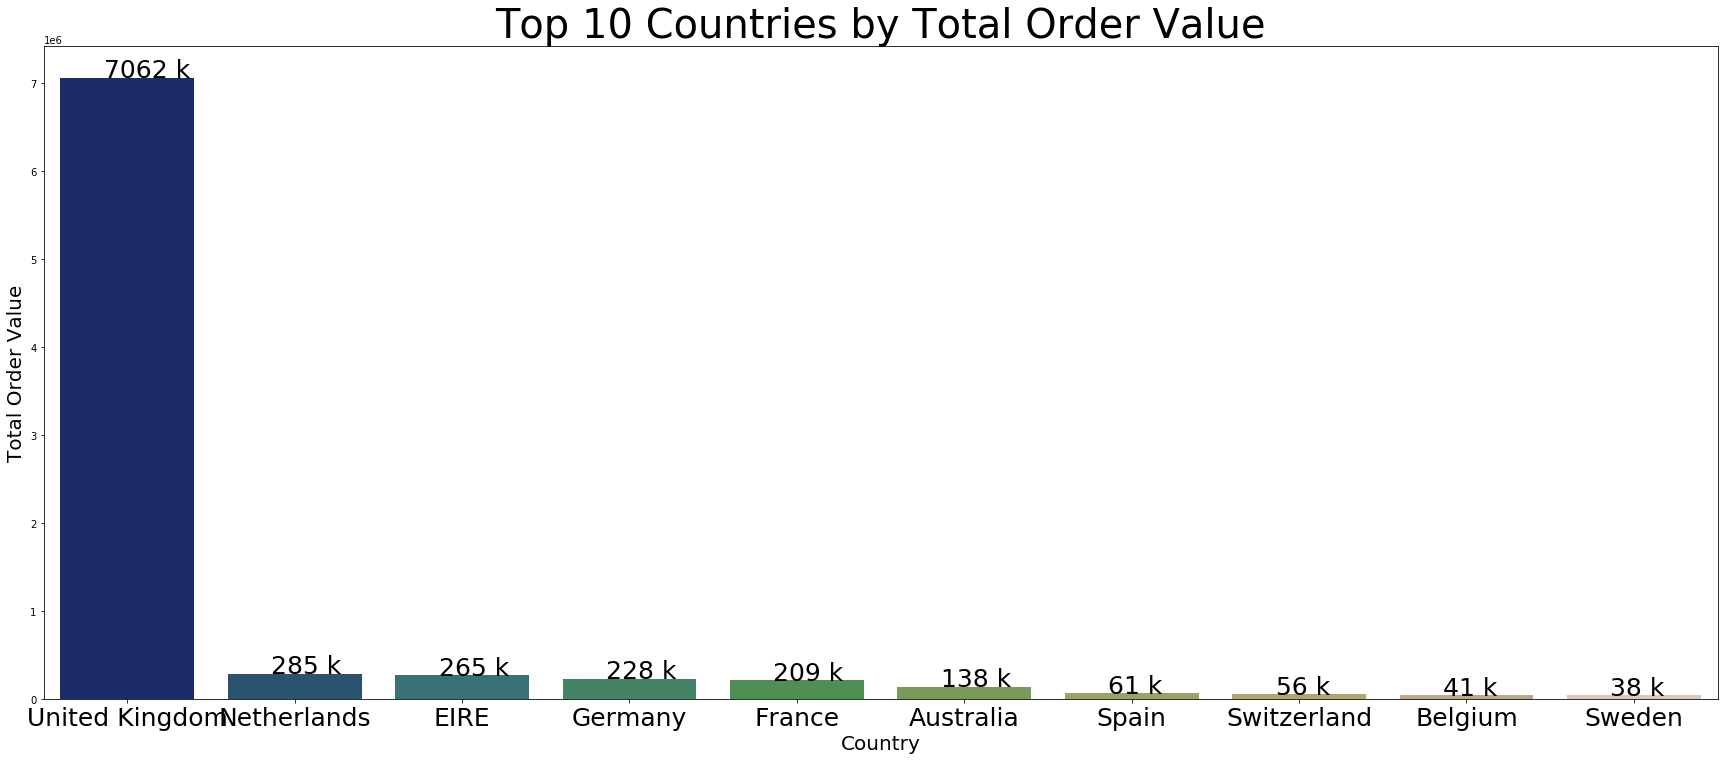

In [22]:
order_country = df.groupby('Country').sum()['Total_sales'].nlargest(10)
plt.figure(figsize=(30,12))
plt.style.use('_classic_test_patch')
px = sns.barplot(x = order_country.index, y = order_country.values, palette = 'gist_earth')
px.set_xlabel('Country', fontsize = 20)
px.set_ylabel('Total Order Value', fontsize = 20)
px.set_title('Top 10 Countries by Total Order Value', fontsize = 40)

labels = [ '\n'.join(wrap(l, 15)) for l in order_country.index ]
px.set_xticklabels(labels, fontsize = 25)

value_ticks = []
for x in order_country.values:
    value_ticks.append(str(int(x/1000))+' k')
value_ticks[0]

for a, label in zip(px.patches, value_ticks):
    px.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

**Observation:**

> As we know this is a UK based store, so maximum sales are from UK.
> There is a lot of difference in the sales in UK vs Other countries.

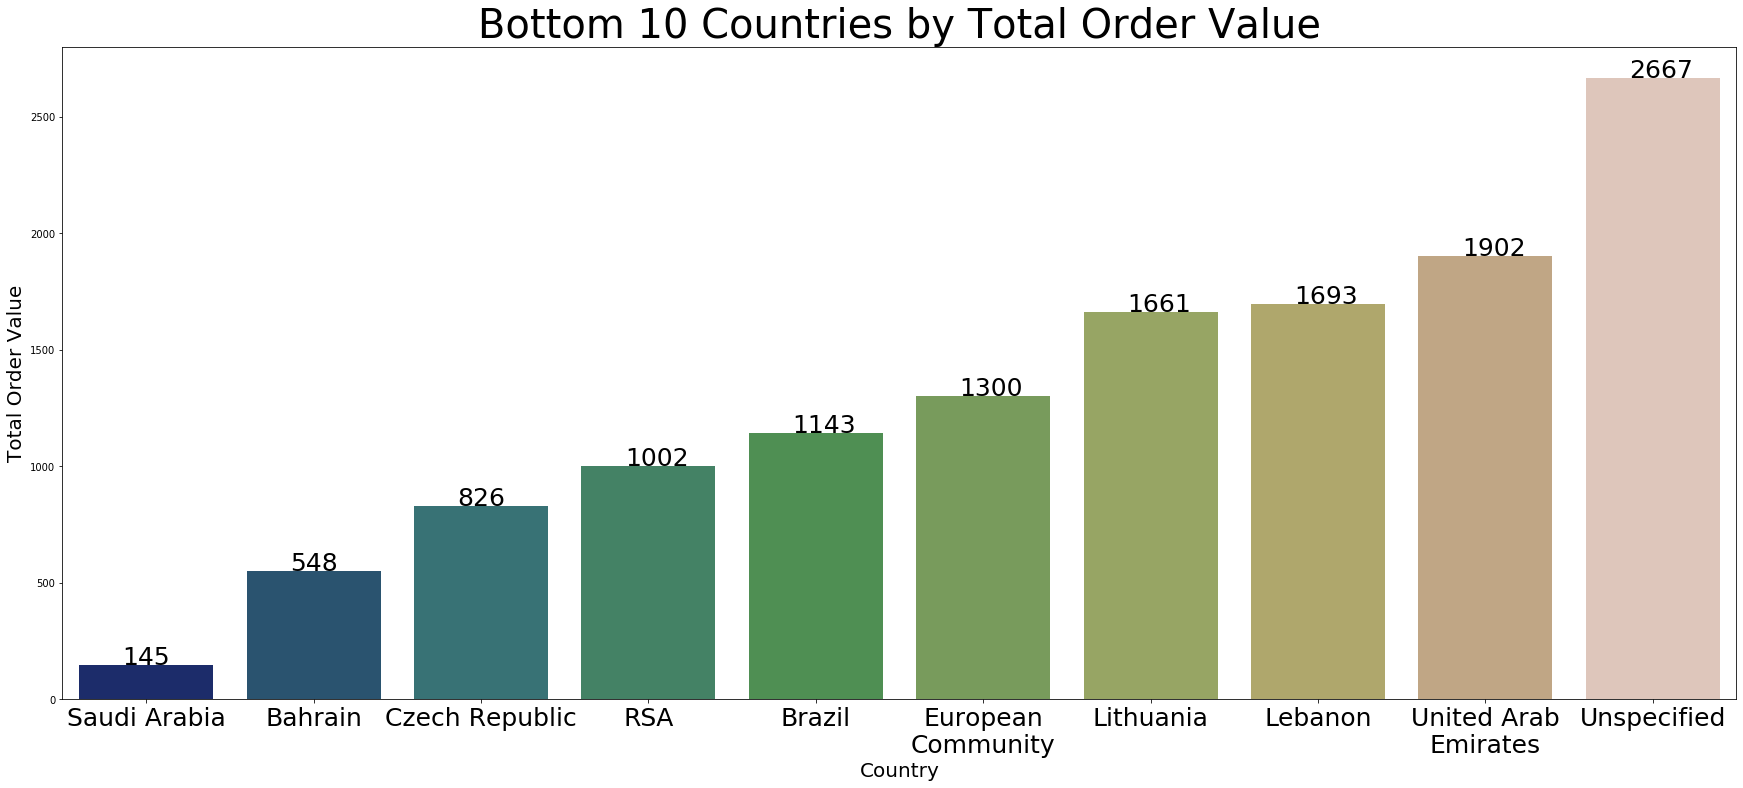

In [23]:
order_country = df.groupby('Country').sum()['Total_sales'].nsmallest(10)
plt.figure(figsize=(30,12))
plt.style.use('_classic_test_patch')
px = sns.barplot(x = order_country.index, y = order_country.values, palette = 'gist_earth')
px.set_xlabel('Country', fontsize = 20)
px.set_ylabel('Total Order Value', fontsize = 20)
px.set_title('Bottom 10 Countries by Total Order Value', fontsize = 40)

labels = [ '\n'.join(wrap(l, 15)) for l in order_country.index ]
px.set_xticklabels(labels, fontsize = 25)

value_ticks = []
for x in order_country.values:
    value_ticks.append(str(int(x)))
value_ticks[0]

for a, label in zip(px.patches, value_ticks):
    px.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

**Observation:**

> We see there are some countries which are no specified. 

> The lowest sales has happened in ``Saudi Arabia``. Could be that they have recently expanded there or we have a limited data

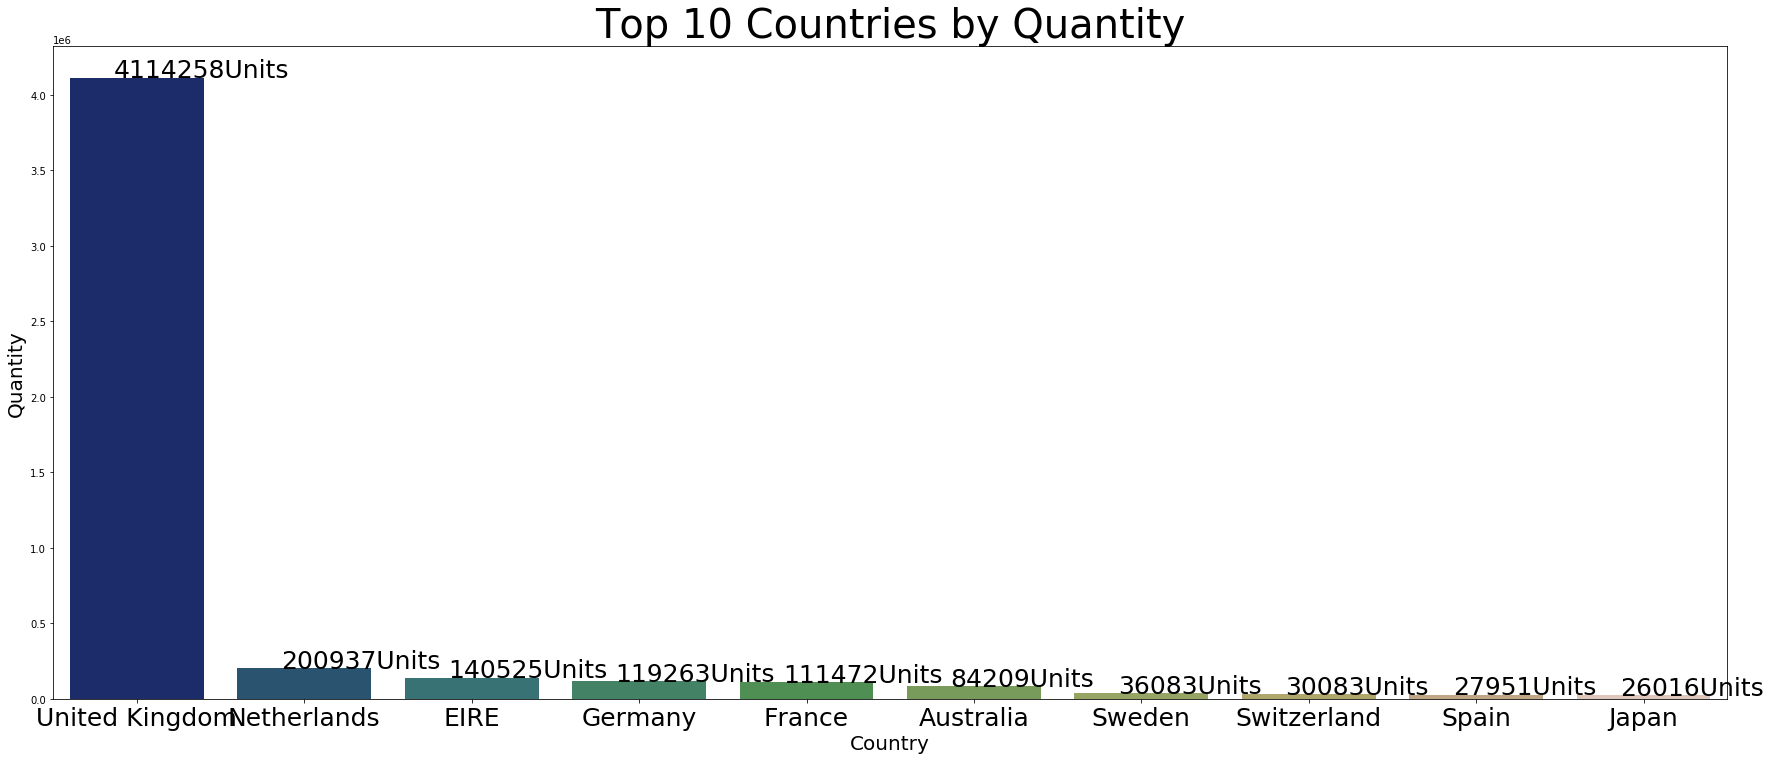

In [24]:
order_country = df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending=False).head(10)
plt.figure(figsize=(30,12))
plt.style.use('_classic_test_patch')
px = sns.barplot(x = order_country.index, y = order_country.values, palette = 'gist_earth')
px.set_xlabel('Country', fontsize = 20)
px.set_ylabel('Quantity', fontsize = 20)
px.set_title('Top 10 Countries by Quantity', fontsize = 40)

labels = [ '\n'.join(wrap(l, 15)) for l in order_country.index ]
px.set_xticklabels(labels, fontsize = 25)

value_ticks = []
for x in order_country.values:
    value_ticks.append(str(int(x))+'Units')
value_ticks[0]

for a, label in zip(px.patches, value_ticks):
    px.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

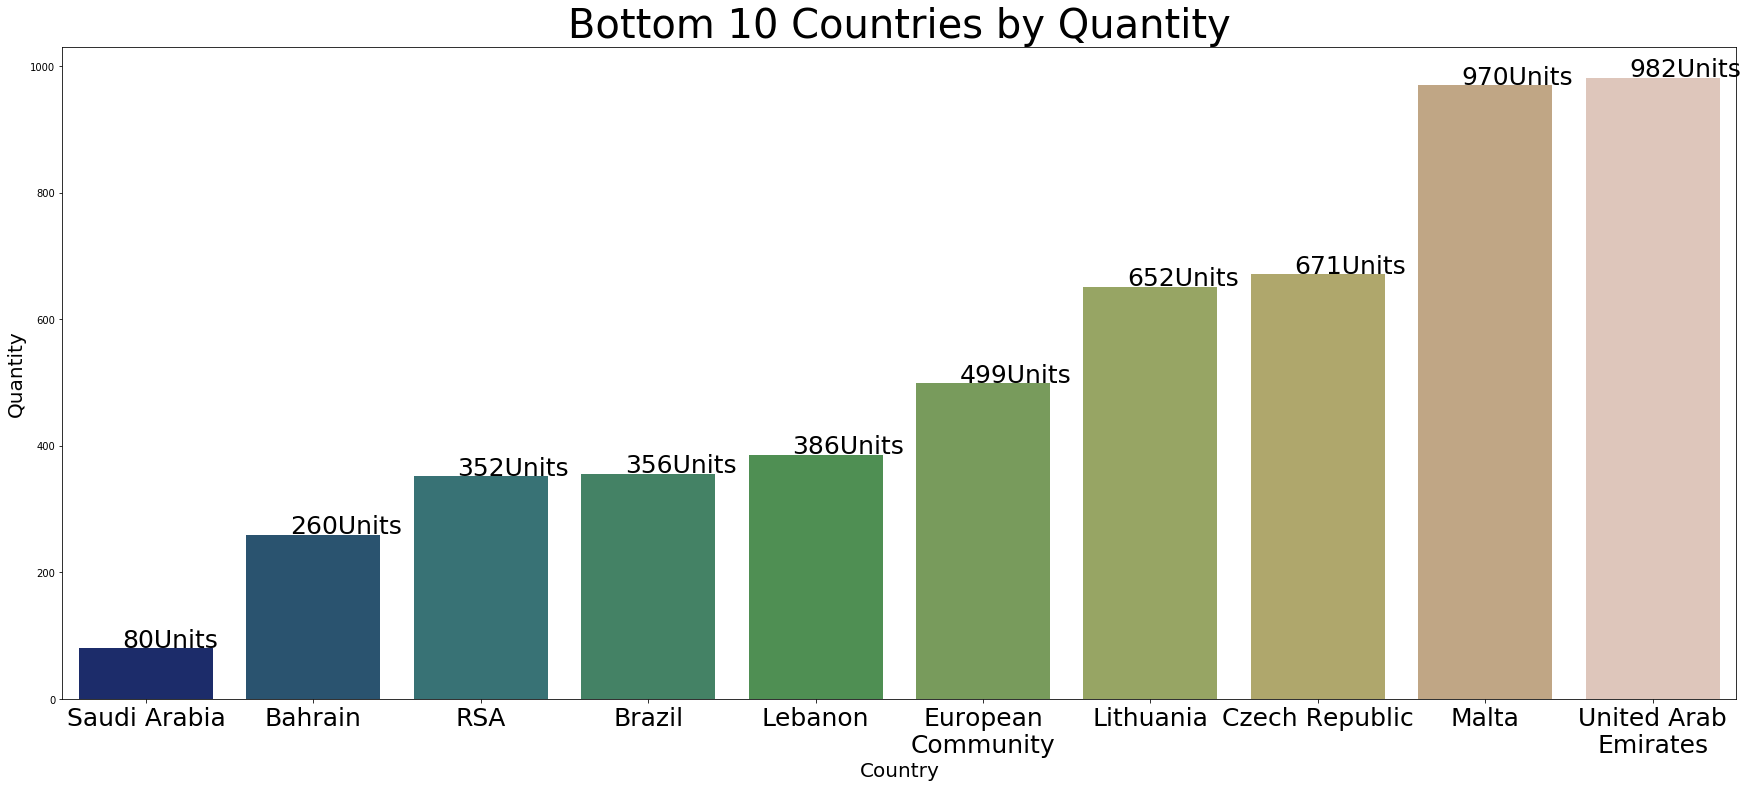

In [25]:
order_country = df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending=True).head(10)
plt.figure(figsize=(30,12))
plt.style.use('_classic_test_patch')
px = sns.barplot(x = order_country.index, y = order_country.values, palette = 'gist_earth')
px.set_xlabel('Country', fontsize = 20)
px.set_ylabel('Quantity', fontsize = 20)
px.set_title('Bottom 10 Countries by Quantity', fontsize = 40)

labels = [ '\n'.join(wrap(l, 15)) for l in order_country.index ]
px.set_xticklabels(labels, fontsize = 25)

value_ticks = []
for x in order_country.values:
    value_ticks.append(str(int(x))+'Units')
value_ticks[0]

for a, label in zip(px.patches, value_ticks):
    px.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

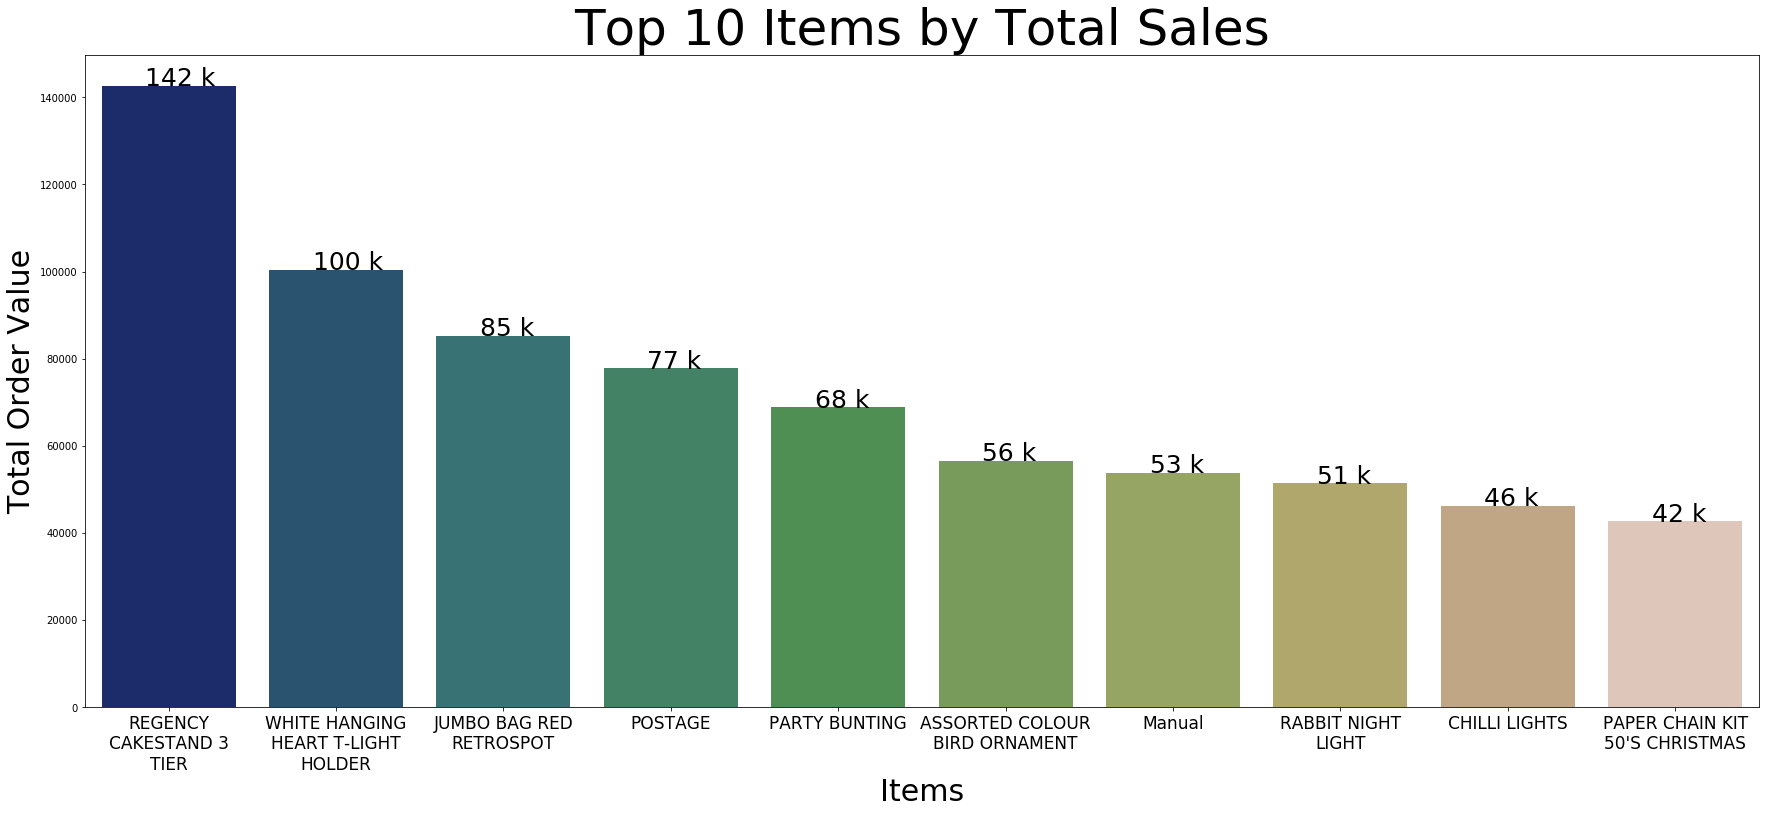

In [26]:
#Total order value by country's

sales_items = df.groupby('Description').sum()['Total_sales'].nlargest(10)
plt.figure(figsize=(30,12))
plt.style.use('_classic_test_patch')
px = sns.barplot(x = sales_items.index, y = sales_items.values, palette = 'gist_earth')
px.set_xlabel('Items', fontsize = 30)
px.set_ylabel('Total Order Value', fontsize = 30)
px.set_title('Top 10 Items by Total Sales', fontsize = 50)

labels_x = [ '\n'.join(wrap(l, 15)) for l in sales_items.index ]
px.set_xticklabels(labels_x, fontsize = 17)

value_ticks = []
for x in sales_items.values:
    value_ticks.append(str(int(x/1000))+' k')

for a, label in zip(px.patches, value_ticks):
    px.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

**Observation:**

> ``Regency Cakestand`` seems one of the favourite items by the customers, total of ``142K`` of Cakestands have been sold in just 11months 9 dyas

## Cohort Analysis

In [27]:
# Creating a copy of the cleaned data
df_cohort = df.copy()

In [28]:
# As we have only 9 days information of December 2011, so we would not use that for cohort analysis.
df_cohort = df_cohort[~(df_cohort['InvoiceDate'] > '2011-12-01')]

In [29]:
# Extracting month and year column from the Invoice date column
df_cohort['invoice_month'] = df_cohort['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))

In [30]:
month_grp = df_cohort.groupby('invoice_month')

month_grp_agg = month_grp.agg({'CustomerID': pd.Series.nunique, 'Description': pd.Series.nunique, 
                               'Quantity': np.sum, 'Total_sales': np.sum})

month_grp_agg.rename(columns ={'CustomerID':'# customers', 'Description':'tot_item_types',}, inplace = True)

month_grp_agg

,# customers,tot_item_types,Quantity,Total_sales
invoice_month,,,,
2010-12,885.0,2418,312276,572705.490
2011-01,740.0,2117,274932,492261.440
2011-02,758.0,2122,265638,447137.350
2011-03,974.0,2240,348544,595500.760
2011-04,856.0,2225,292225,469200.361
2011-05,1056.0,2255,373685,678594.560
2011-06,991.0,2361,363699,661213.690
2011-07,949.0,2373,369432,600091.011
2011-08,935.0,2386,398938,645343.900


In [31]:
#Creating Label for customer cohort
df_cohort.set_index('CustomerID', inplace = True)
df_cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Total_sales,invoice_month
CustomerID,,,,,,,,,
16126.0,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,United Kingdom,30.00,2011-06
18118.0,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,United Kingdom,5.10,2011-05
15529.0,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,United Kingdom,0.85,2011-01
14448.0,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,United Kingdom,19.50,2010-12
13911.0,552306,84789,ENCHANTED BIRD PLANT CAGE,4,2011-05-08 15:20:00,3.75,United Kingdom,15.00,2011-05


In [32]:
df_cohort['cust_cohort'] = df_cohort.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df_cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Total_sales,invoice_month,cust_cohort
CustomerID,,,,,,,,,,
16126.0,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,United Kingdom,30.00,2011-06,2011-02
18118.0,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,United Kingdom,5.10,2011-05,2010-12
15529.0,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,United Kingdom,0.85,2011-01,2010-12
14448.0,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,United Kingdom,19.50,2010-12,2010-12
13911.0,552306,84789,ENCHANTED BIRD PLANT CAGE,4,2011-05-08 15:20:00,3.75,United Kingdom,15.00,2011-05,2011-02


In [33]:
df_cohort.reset_index(inplace = True)
df_cohort.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Total_sales,invoice_month,cust_cohort
0,16126.0,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,United Kingdom,30.00,2011-06,2011-02
1,18118.0,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,United Kingdom,5.10,2011-05,2010-12
2,15529.0,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,United Kingdom,0.85,2011-01,2010-12
3,14448.0,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,United Kingdom,19.50,2010-12,2010-12
4,13911.0,552306,84789,ENCHANTED BIRD PLANT CAGE,4,2011-05-08 15:20:00,3.75,United Kingdom,15.00,2011-05,2011-02


In [34]:
cust_grp = df_cohort.groupby(['cust_cohort','invoice_month'])

cust_grp_agg = cust_grp.agg({'CustomerID': pd.Series.nunique, 'Description': pd.Series.nunique,
                      'Quantity': np.sum, 'Total_sales': np.sum})

cust_grp_agg.rename(columns ={'CustomerID':'# customers', 'Description':'tot_item_types',}, inplace = True)

cust_grp_agg.head()

# customers  tot_item_types  Quantity  Total_sales
cust_cohort invoice_month                                                    
2010-12     2010-12              885.0            2418    312276    572705.49
            2011-01              324.0            1787    158708    276237.69
            2011-02              286.0            1697    136860    233845.37
            2011-03              340.0            1834    177580    303119.39
            2011-04              321.0            1781    131378    204407.66

In [35]:
def cohort_num(df_cohort):
    df_cohort['cohort_num'] = np.arange(len(df_cohort)) + 1
    return df_cohort

cust_grp_agg = cust_grp_agg.groupby(level=0).apply(cohort_num)
cust_grp_agg.head(10)

# customers  tot_item_types  ...  Total_sales  cohort_num
cust_cohort invoice_month                               ...                         
2010-12     2010-12              885.0            2418  ...    572705.49           1
            2011-01              324.0            1787  ...    276237.69           2
            2011-02              286.0            1697  ...    233845.37           3
            2011-03              340.0            1834  ...    303119.39           4
            2011-04              321.0            1781  ...    204407.66           5
            2011-05              352.0            1851  ...    336627.50           6
            2011-06              321.0            1871  ...    314162.61           7
            2011-07              309.0            1954  ...    310783.92           8
            2011-08              313.0            1952  ...    331749.22           9
            2011-09              350.0            2138  ...    472813.64          10

[10 rows x 5 columns]

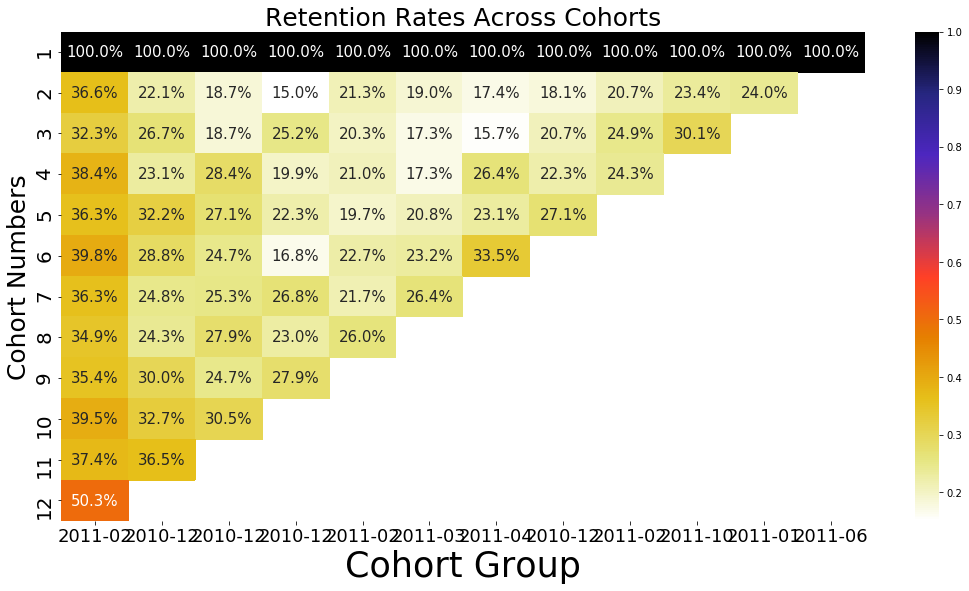

In [36]:
cust_grp_agg.reset_index(inplace=True)
cust_grp_agg.set_index(['cust_cohort', 'cohort_num'], inplace=True)

cohort_size = cust_grp_agg.groupby(level=0)['# customers'].first()
retention_rate = cust_grp_agg['# customers'].unstack(0).divide(cohort_size, axis = 1)

plt.figure(figsize=(18,9))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(retention_rate, annot=True,cmap='CMRmap_r', fmt='.1%', annot_kws={'size': 15})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Retention Rates Across Cohorts', fontsize = 25);

**Observation:**
> The first cohort (2010–12) seems to be an exception and performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 50% retention.

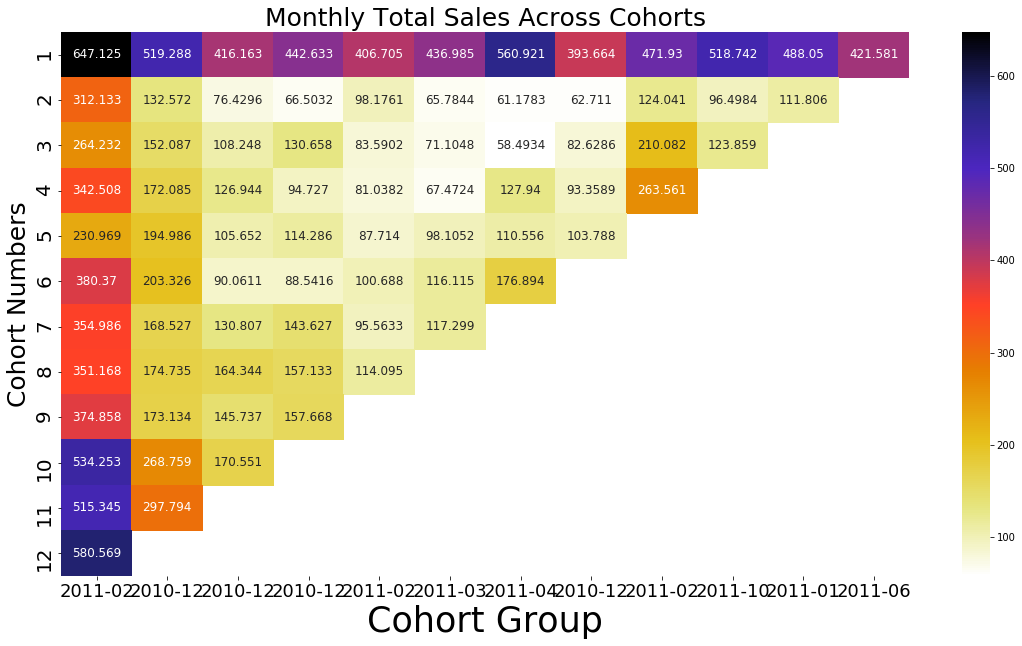

In [37]:
cust_grp_agg.reset_index(inplace=True)
cust_grp_agg.set_index(['cust_cohort', 'cohort_num'], inplace=True)

cohort_size = cust_grp_agg.groupby(level=0)['# customers'].first()
retention_rate = cust_grp_agg['Total_sales'].unstack(0).divide(cohort_size, axis = 1)

plt.figure(figsize=(19,10))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(retention_rate, annot=True,cmap='CMRmap_r', fmt='g', annot_kws={'size': 12})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Monthly Total Sales Across Cohorts', fontsize = 25);

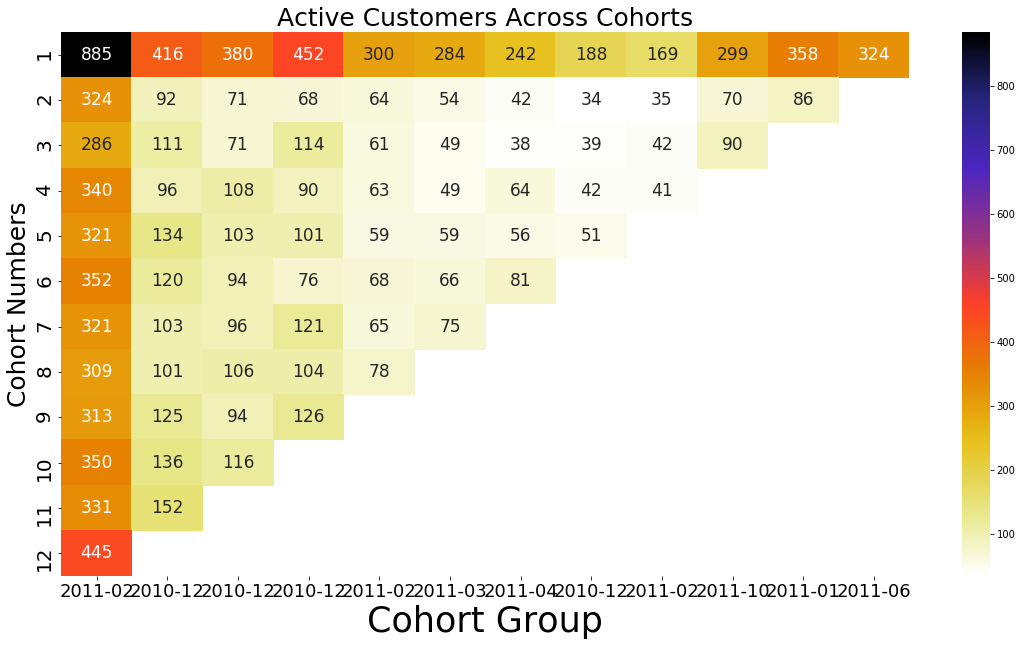

In [38]:
unstacked_cust = cust_grp_agg['# customers'].unstack(0)
plt.figure(figsize=(19,10))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(unstacked_cust, annot = True, cmap='CMRmap_r', fmt = 'g', annot_kws={'size': 17})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Active Customers Across Cohorts', fontsize = 25);

**Observation:**

> While not entirely representative as these are only sale figures across a single year, it is clear that the number of customers and sales figures are much higher for the first 2010–12 cohort. A more representative way of understanding this cohort is that they are existing customer that have a prior relationship with this store. It is thus natural for them to demonstrate much higher customer engagement and activity.

> There also seems to be a slight seasonal factor underlying the sales of this online retailer. Initial purchases are higher in the first and last quarters of the year. Similarly, purchases from the 2010–12 cohort indicate higher activity during these two quarters as well. As most of the products are gifts, this increased activity could be attributed to the holiday season represented by these time periods.

## ``Project Task: Week 2``

**Data Modeling :**

1. Build a ``RFM (Recency Frequency Monetary) model``. Recency means the number of days since a customer made the last purchase. Frequency is the number of purchase in a given period. It could be 3 months, 6 months or 1 year. Monetary is the total amount of money a customer spent in that given period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP.

2. Calculate RFM metrics.

3. Build RFM Segments. Give recency, frequency, and monetary scores individually by dividing them into quartiles.

    b1. Combine three ratings to get a RFM segment (as strings).

    b2. Get the RFM score by adding up the three ratings.

    b3. Analyze the RFM segments by summarizing them and comment on the findings.

Note: Rate ``“recency"`` for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent.

Note: Rate ``“frequency"`` and ``“monetary"`` higher, because the company wants the customer to visit more often and spend more money

In [39]:
# Creating a copy of the original dataframe which will have records of December 2011 as well
rfm_df = df.copy(deep=True)

In [40]:
# Checking for duplicates
rfm_df.duplicated().sum()

5192

In [41]:
# Dropping all the duplicated records
rfm_df.drop_duplicates(inplace = True)

In [42]:
rfm_df.duplicated().sum()

0

In [43]:
rfm_df.shape

(392729, 9)

In [44]:
# The last transaction date we have is 12-09-2011, so we would take that as current date to calculate the recency
import datetime as dt
last_date = df['InvoiceDate'].max()

In [45]:
RFM_table = rfm_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency
                                        'InvoiceNo': 'count',               # Frequency
                                        'Total_sales': 'sum'})                # Monetary Value

RFM_table.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Total_sales': 'Monetary'}, inplace=True)

RFM_table.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04
12353.0,203,4,89.00
12354.0,231,58,1079.40
12355.0,213,13,459.40
12356.0,22,59,2811.43


In [46]:
RFM_table.reset_index(inplace = True)

In [47]:
quartiles = RFM_table.quantile(q=[0.25,0.50,0.75])
quartiles = quartiles.to_dict()

In [48]:
RFM_table_copy = RFM_table.copy()

> We will split the metrics into segments using quantiles.

> Assigning a score from ``4 to 1 to Recency`` and from ``1 to 4 to Frequency and Monetary``. 

> ``4`` is the ``best/highest`` value for ``Recency``, and ``1 is the lowest/worst value``.

> ``1`` is the ``the lowest/worst value`` value for ``Frquency & Monetary``, and ``4 is ``best/highest``. 

> An ``RFM score`` will be calculated by joining individual R F M score numbers.

In [49]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [50]:
RFM_table_copy['R'] = RFM_table_copy['Recency'].apply(RScore, args=('Recency',quartiles))
RFM_table_copy['F'] = RFM_table_copy['Frequency'].apply(FMScore, args=('Frequency',quartiles))
RFM_table_copy['M'] = RFM_table_copy['Monetary'].apply(FMScore, args=('Monetary',quartiles))

In [51]:
RFM_table_copy['RFM'] = RFM_table_copy.R.map(str)+RFM_table_copy.F.map(str)+RFM_table_copy.M.map(str)

In [52]:
RFM_table_copy['RFM_Score'] = RFM_table_copy[['R','F','M']].sum(axis=1)
RFM_table_copy.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
0,12347.0,1,182,4310.00,4,4,4,444,12
1,12348.0,74,31,1797.24,2,2,4,224,8
2,12349.0,18,73,1757.55,3,3,4,334,10
3,12350.0,309,17,334.40,1,1,2,112,4
4,12352.0,35,85,2506.04,3,3,4,334,10


In [53]:
RFM_table_copy.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           259.6       8.2    157.0   382
4           176.2      13.6    240.0   388
5           152.1      21.2    366.7   517
6            94.3      27.9    649.7   455
7            78.6      37.9    759.1   465
8            63.0      55.9    986.6   455
9            45.1      78.9   1391.5   413
10           31.5     110.6   2057.4   425
11           20.3     186.7   4055.8   388
12            6.2     367.9   9285.9   450

In [54]:
# Setting up the label for each client and adding the column "Label" to the dataframe

Segment = [0] * len(RFM_table_copy)

for i in range(0,len(RFM_table_copy)):

    if RFM_table_copy['RFM'][i] == '444':
        Segment[i] = "Platinum"
     
    elif RFM_table_copy['RFM'][i] == '413':
        Segment[i] = "Gold"
        
    elif RFM_table_copy['RFM'][i] == '323':
        Segment[i] = "Silver"    
        
    else:
        Segment[i] = "Bronze"

In [55]:
RFM_table_copy['Segment'] = Segment

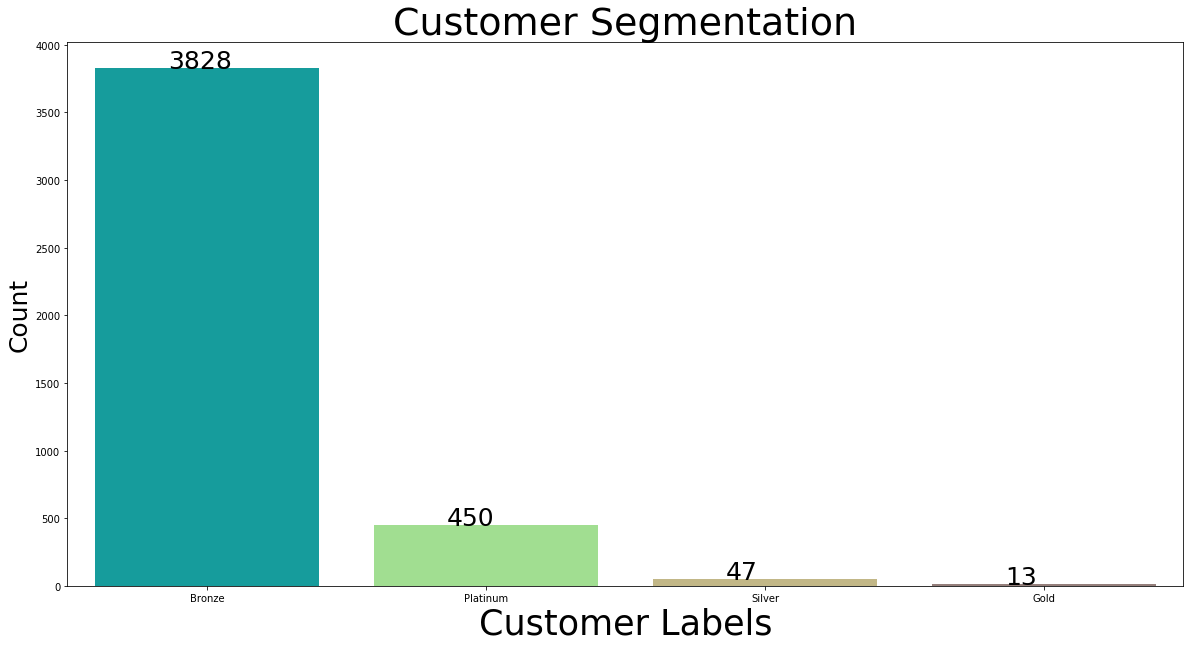

In [56]:
plt.figure(figsize=(20,10))
plt.style.use('_classic_test_patch')
ax = sns.countplot(x='Segment', data=RFM_table_copy, palette="terrain", order=RFM_table_copy['Segment'].value_counts().index[:5])
ax.set_ylabel('Count', fontsize = 25)
ax.set_xlabel('Customer Labels', fontsize = 35)
#ax.set_xticklabels(rfm_table['Label'].index, fontsize = 25)
ax.set_title('Customer Segmentation', fontsize = 38);

#labels_x = [ '\n'.join(wrap(l, 15)) for l in rfm_table['Label'].index ]
#ax.set_xticklabels(labels_x, fontsize = 19)

value_ticks = []
for x in RFM_table_copy['Segment'].value_counts():
    value_ticks.append(str(int(x)))

for a, label in zip(ax.patches, value_ticks):
    ax.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

In [57]:
RFM_table_copy.groupby('Segment').agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
            mean      mean     mean count
Segment                                  
Bronze     102.5      58.9   1150.8  3828
Gold         9.4      11.9   1081.5    13
Platinum     6.2     367.9   9285.9   450
Silver      33.3      31.8    923.4    47

In [58]:
def skewness(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 1.2457125234954753, : SkewtestResult(statistic=26.608212114006275, pvalue=5.454166575151001e-156)
Frequency's: Skew: 18.036037104330713, : SkewtestResult(statistic=83.48256629177025, pvalue=0.0)
Monetary's: Skew: 20.624815446376257, : SkewtestResult(statistic=86.43722008800934, pvalue=0.0)


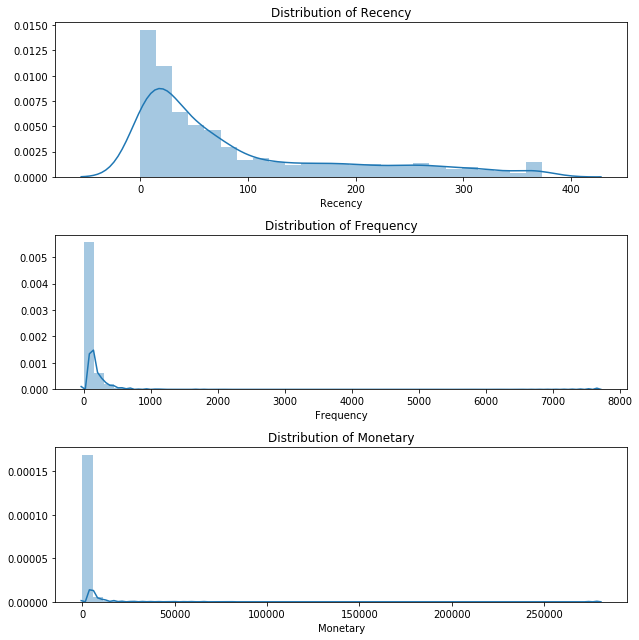

In [59]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
skewness(RFM_table_copy,'Recency')

plt.subplot(3, 1, 2)
skewness(RFM_table_copy,'Frequency')

plt.subplot(3, 1, 3)
skewness(RFM_table_copy,'Monetary')

plt.tight_layout()

**Observation:**

> The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable.

> A small constant would also be needed as log transformation demands all the values to be positive.

## ``Project Task Week 3``

**Data Modeling :**

1. Create clusters using k-means clustering algorithm.

    a. Prepare the data for the algorithm. If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardize the data.

    b. Decide the optimum number of clusters to be formed.

    c. Analyze these clusters and comment on the results.

In [60]:
df_rfm_log = RFM_table.copy()
print(df_rfm_log.describe())

         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.617796    91.511757    90.532273    1992.057929
std     1721.503870    99.963616   225.537197    8546.651225
min    12347.000000     0.000000     1.000000       0.000000
25%    13813.250000    17.000000    17.000000     306.210000
50%    15299.500000    50.000000    41.000000     668.040000
75%    16778.750000   141.000000    98.000000    1656.537500
max    18287.000000   373.000000  7676.000000  280206.020000


Recency's: Skew: -0.553047774132005, : SkewtestResult(statistic=-13.947408787843337, pvalue=3.262444980776586e-44)
Frequency's: Skew: -0.012391467138597751, : SkewtestResult(statistic=-0.3337508666486869, pvalue=0.7385675621614818)
Monetary's: Skew: 0.32711188981018624, : SkewtestResult(statistic=8.59167125141112, pvalue=8.571333684337599e-18)


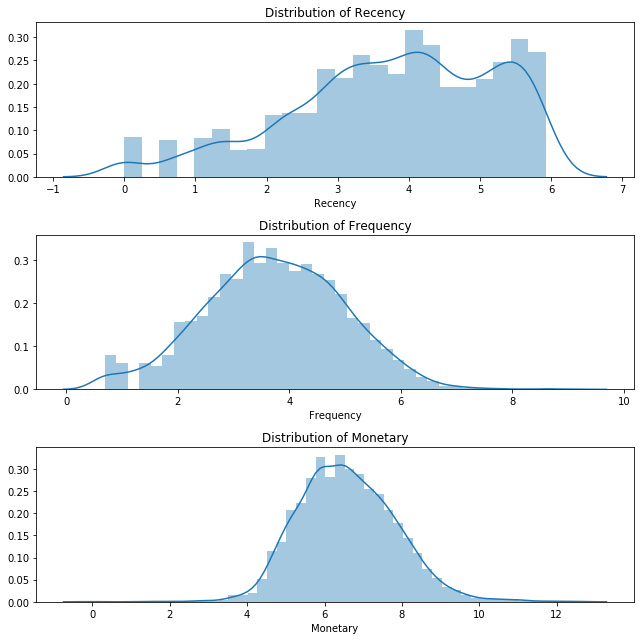

In [61]:
# A constant of 1 is added to the log to ensure we have all positive values
df_rfm_log = np.log(df_rfm_log+1)
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
skewness(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
skewness(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
skewness(df_rfm_log,'Monetary')

plt.tight_layout()

In [62]:
print(df_rfm_log.describe())

        CustomerID      Recency    Frequency     Monetary
count  4338.000000  4338.000000  4338.000000  4338.000000
mean      9.629314     3.768036     3.729132     6.583507
std       0.113513     1.431272     1.245280     1.260195
min       9.421249     0.000000     0.693147     0.000000
25%       9.533456     2.890372     2.890372     5.727531
50%       9.635641     3.931826     3.737670     6.505844
75%       9.727928     4.955827     4.595120     7.413088
max       9.814000     5.924256     8.945984    12.543284


In [63]:
# Standardrizing the data
scaler = StandardScaler()
scaler.fit(df_rfm_log)

# Store it separately for clustering
rfm_scaled= scaler.transform(df_rfm_log)

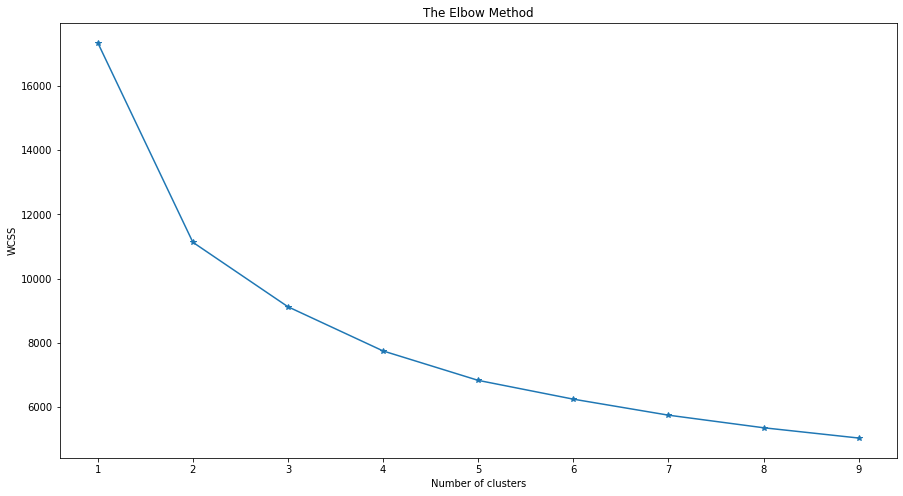

In [64]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

f, ax = plt.subplots(figsize=(15, 8))  
plt.style.use('_classic_test_patch')  
plt.plot(range(1, 10), wcss, '-*')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS');

**Observation:**

> We can see there is a sharp turn from the 4 point. We can select values between 4 to 6 for our clusters.

> Lets plot all the clusters 4, 5 & 6 to see which is defined better.

In [65]:
def kmeans(rfm_scaled, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_scaled)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

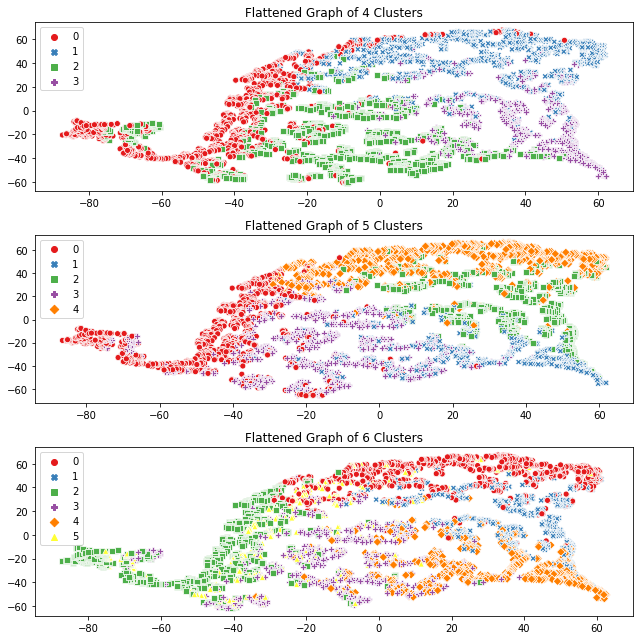

In [66]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
df_rfm_k4 = kmeans(rfm_scaled, 4, RFM_table)

plt.subplot(3, 1, 2)
df_rfm_k5 = kmeans(rfm_scaled, 5, RFM_table)

plt.subplot(3, 1, 3)
df_rfm_k6 = kmeans(rfm_scaled, 6, RFM_table)

plt.tight_layout()

In [67]:
def wire_plot(rfm_scaled, df_rfm_kmeans, df_rfm_original):

    rfm_scaled = pd.DataFrame(rfm_scaled, 
                                       index=RFM_table.index, 
                                       columns=RFM_table.columns)
    rfm_scaled['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(rfm_scaled.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

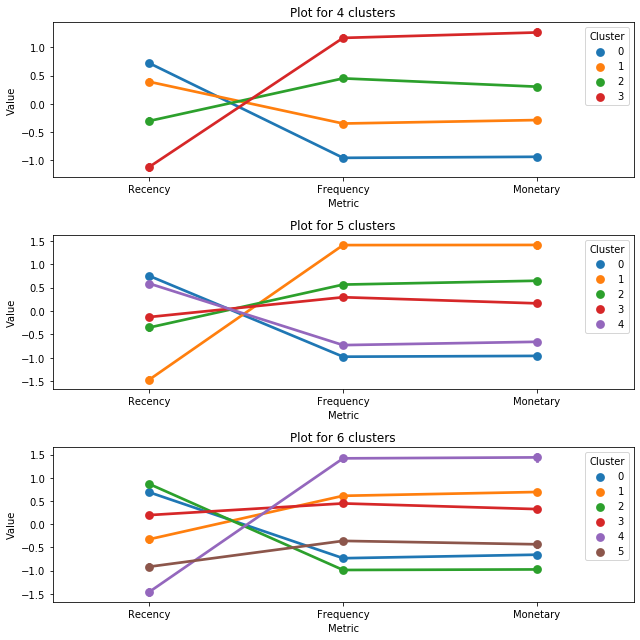

In [68]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Plot for 4 clusters')
wire_plot(rfm_scaled, df_rfm_k4, RFM_table)

plt.subplot(3, 1, 2)
plt.title('Plot for 5 clusters')
wire_plot(rfm_scaled, df_rfm_k5, RFM_table)

plt.subplot(3, 1, 3)
plt.title('Plot for 6 clusters')
wire_plot(rfm_scaled, df_rfm_k6, RFM_table)

plt.tight_layout()

In [69]:
# clustering
kc = KMeans(n_clusters= 4, random_state=42)
kc.fit(rfm_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
df_rfm_k4 = df_rfm_log.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
df_rfm_k4.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'Monetary': ['mean', 'count'],}).round(0)

Recency Frequency Monetary      
             mean      mean     mean count
K_Cluster                                 
0             5.0       3.0      5.0  1131
1             2.0       5.0      8.0   826
2             4.0       3.0      6.0  1195
3             3.0       4.0      7.0  1186

In [70]:
rfm_scaled = pd.DataFrame(rfm_scaled,index=RFM_table.index,columns=RFM_table.columns)
rfm_scaled['K_Cluster'] = kc.labels_
rfm_scaled['Segment'] = RFM_table_copy['Segment']
rfm_scaled['CustomerID'] = RFM_table_copy['CustomerID']
rfm_scaled.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_scaled,id_vars=['CustomerID','Segment','K_Cluster'],value_vars=['Recency', 'Frequency', 'Monetary'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,CustomerID,Segment,K_Cluster,Metric,Value
0,12347.0,Platinum,1,Recency,-2.148608
1,12348.0,Bronze,2,Recency,0.383935
2,12349.0,Bronze,1,Recency,-0.575496
3,12350.0,Bronze,2,Recency,1.375533
4,12352.0,Bronze,1,Recency,-0.128933


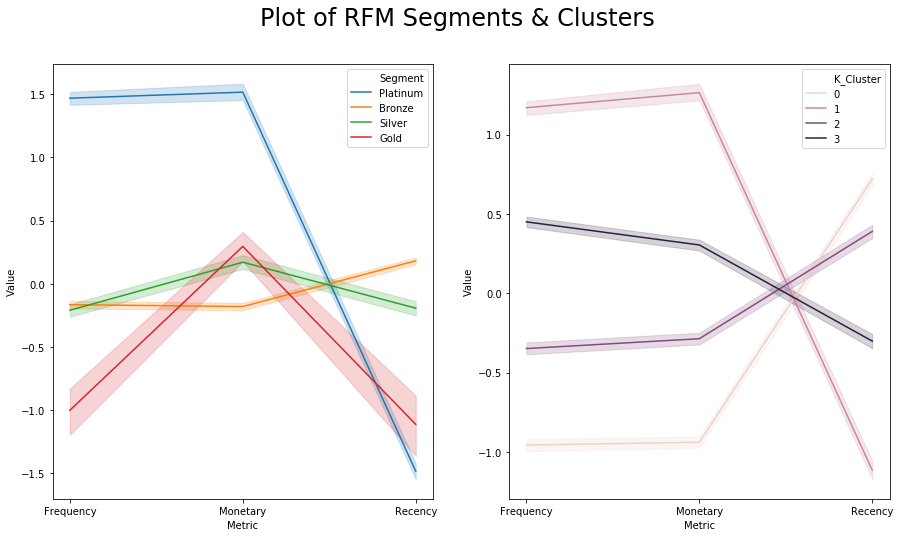

In [71]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)

plt.suptitle("Plot of RFM Segments & Clusters",fontsize=24)
plt.show()

**Observation:**

``Conclusion``

> The first cluster belongs to the ``"Best Customers" / "Platinum Customers"`` segment as they purchase recently (R=4), frequent buyers (F=1), and spent the most (M=1).

> The second cluster can be interpreted as ``"Newbies" / "Gold" customers`` as their last purchase is very recent (R=4), purchased very few (F=1) but spent quite a good amount (M=4).Company has to come up with new strategies to make them permanent members.

> The third cluster is more related to the ``"Best Churned Customers" / "Silver Customers"`` as they have made a purchase for some time (R=3), visited not much (F=2) but have spent a decent amount of money.

> The last cluster are belogns to ``Bronze Cutomers``, who are in a mixed fashion and can be classified furthermore to give them the best treatment.

## ``Project Task: Week 4``
Data Reporting:

Please on the link below to see my work on Tableau Dashboard: https://public.tableau.com/profile/khushboo.nagdewani#!/vizhome/Capstone_new/RFMAnalysis